In [23]:
import pandas as pd
df=pd.read_csv('Master_File.csv')

Total number of compounds with 1 to 7 crystal systems:
class_count
1    4502
2     540
3     148
4      62
5      20
6       6
7       1
Name: count, dtype: int64


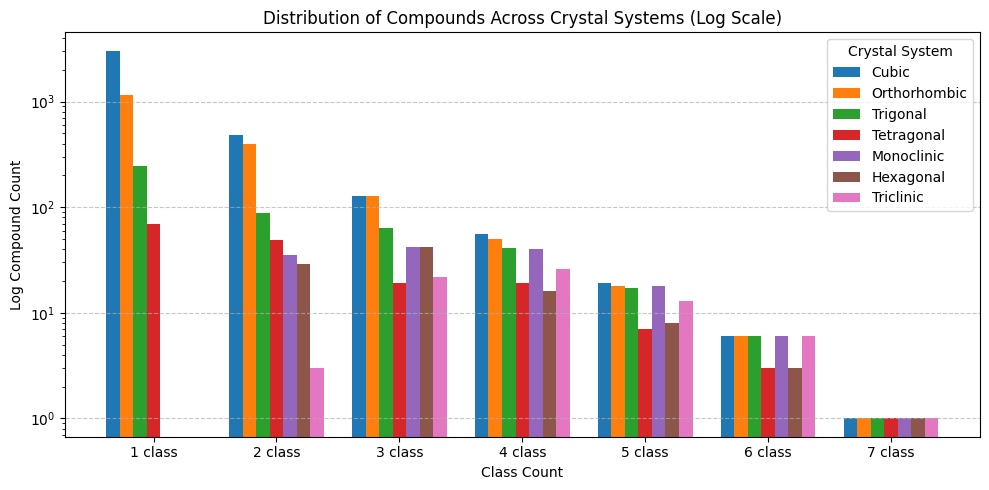

In [24]:
# ---------------- Compound Class Distribution $  Visualization ----------------
import pandas as pd
import matplotlib.pyplot as plt
import numpy as np
import seaborn as sns

df['Formula'] = df['Formula'].astype(str).str.strip()
df['crystal_system'] = df['crystal_system'].astype(str).str.strip()

#Count
compound_class_counts = df.groupby('Formula')['crystal_system'].nunique().reset_index()
compound_class_counts.columns = ['Formula', 'class_count']
df = df.merge(compound_class_counts, on='Formula', how='left')

df_unique = df[['Formula', 'crystal_system', 'class_count']].drop_duplicates()
grouped = df_unique.groupby(['class_count', 'crystal_system']).size().reset_index(name='CompoundCount')

# ---  Total compound counts per class count ---
total_counts = compound_class_counts['class_count'].value_counts().sort_index()
print("Total number of compounds with 1 to 7 crystal systems:")
print(total_counts)

# --- Prepare data matrix for plotting ---
crystal_systems = [
    'Cubic', 'Orthorhombic', 'Trigonal',
    'Tetragonal', 'Monoclinic', 'Hexagonal', 'Triclinic'
]

# Build data array dynamically from grouped counts
max_class_count = compound_class_counts['class_count'].max()
data = np.zeros((len(crystal_systems), max_class_count), dtype=int)

for _, row in grouped.iterrows():
    class_idx = row['class_count'] - 1  # class_count starts at 1
    system_idx = crystal_systems.index(row['crystal_system'])
    data[system_idx, class_idx] = row['CompoundCount']

# --- Plot grouped bar chart (log scale) ---
class_labels = [f"{i} class" for i in range(1, max_class_count + 1)]
x = np.arange(len(class_labels))  # x-ticks
width = 0.11  # bar width

fig, ax = plt.subplots(figsize=(10, 5))

for i, system in enumerate(crystal_systems):
    offset = (i - len(crystal_systems)/2) * width + width/2
    ax.bar(x + offset, data[i], width, label=system)

ax.set_yscale('log')
ax.set_xlabel('Class Count')
ax.set_ylabel('Log Compound Count')
ax.set_title('Distribution of Compounds Across Crystal Systems (Log Scale)')
ax.set_xticks(x)
ax.set_xticklabels(class_labels)
ax.legend(title='Crystal System')

plt.grid(axis='y', linestyle='--', alpha=0.7)
plt.tight_layout()

# Save plots
plt.savefig("grouped_bar_log_300dpi.png", dpi=300, bbox_inches="tight")
plt.show()


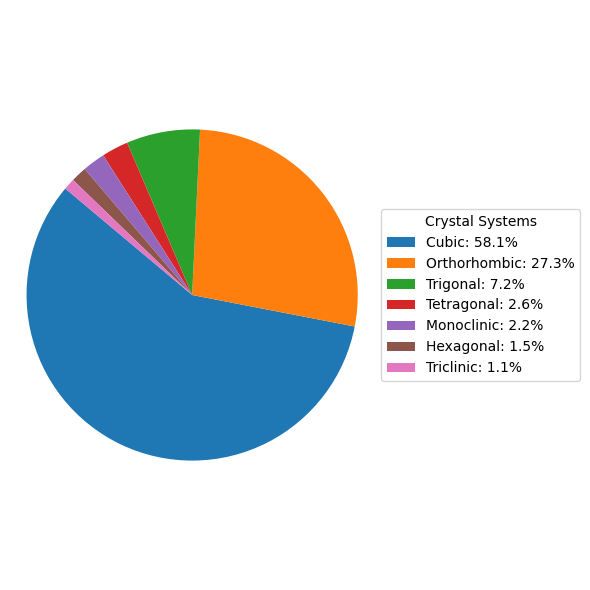

In [2]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Count occurrences of each crystal system
crystal_counts = df["crystal_system"].value_counts()
crystal_systems = crystal_counts.index
counts = crystal_counts.values
total = sum(counts)

# Create labels with name + percentage
legend_labels = [
    f"{name}: {count / total * 100:.1f}%"
    for name, count in zip(crystal_systems, counts)
]

# Plotting
plt.figure(figsize=(6,6))
wedges, _ = plt.pie(counts, startangle=140)
plt.legend(
    wedges, legend_labels,
    title="Crystal Systems",
    loc="center left",
    bbox_to_anchor=(1, 0, 0.5, 1)
)
plt.axis('equal')
plt.tight_layout()

# Save as PNG with 400 dpi
plt.savefig("crystal_systems_pie.png", dpi=400, bbox_inches="tight")

plt.show()

Index(['ARR_A', 'ARR_B', 'MPR_A', 'MPR_B', 'END_A', 'END_B', 'OF', 't',
       'BL_AB', 'BL_AX', 'BL_BX', 'ENR', 'r_A12', 'IE_A', 'D_A', 'TC_A',
       'VLC_A', 'BP_A', 'VR_A', 'AM_A', 'IE_B', 'D_B', 'TC_B', 'VLC_B', 'BP_B',
       'VR_B', 'AM_B'],
      dtype='object')


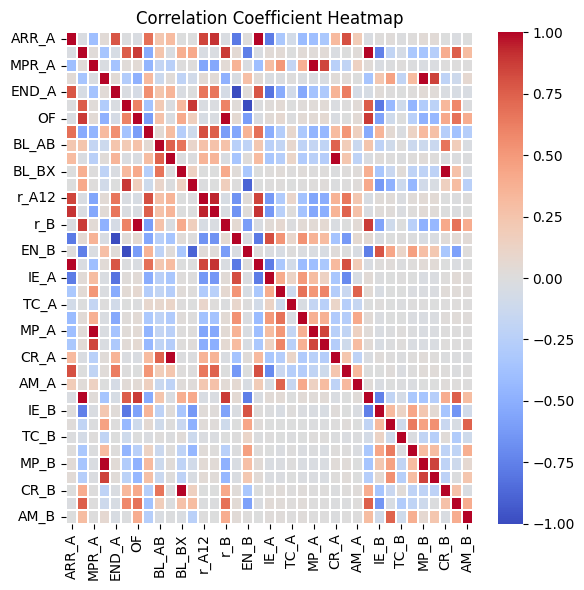

✅ Saved as 'Master_V7_new_decorrelated.csv'
✅ Heatmap saved as 'correlation_heatmap.png' (400 dpi)


In [4]:
# Correlation coefficient
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt

# --- keep only numeric features for the correlation check ---
df_numeric = df.drop(columns=["Formula", "A", "B", "crystal_system"])

correlation_matrix = df_numeric.corr()
upper = correlation_matrix.abs().where(
    np.triu(np.ones(correlation_matrix.shape), k=1).astype(bool))

# Drop features with correlation > 0.9
to_drop = [col for col in upper.columns if any(upper[col] > 0.9)]
X = df_numeric.drop(columns=to_drop)

print(X.columns)                        # remaining numeric columns

# Plot the heatmap
plt.figure(figsize=(6, 6))
sns.heatmap(correlation_matrix, annot=False,
            cmap="coolwarm", fmt=".2f", linewidths=1.2)
plt.title("Correlation Coefficient Heatmap")
plt.tight_layout()
plt.show()

#re-attach the dropped columns

meta_cols = ["Formula", "A", "B", "crystal_system"]
meta_df   = df[meta_cols]               # grab the originals from 'df'

decorrelated_df = pd.concat([X, meta_df], axis=1)

decorrelated_df.to_csv("Master_V7_new_decorrelated.csv", index=False)
print("✅ Saved as 'Master_V7_new_decorrelated.csv'")
print("✅ Heatmap saved as 'correlation_heatmap.png' (400 dpi)")

# Creation of M7

In [5]:
# ---------------- Balance Dataset with SMOTE ----------------
import pandas as pd
from imblearn.over_sampling import SMOTE
from sklearn.preprocessing import LabelEncoder

# Load the dataset
df = pd.read_csv('Master_V7_new_decorrelated.csv')

# Identify the target column
y = df['crystal_system']  # Target variable

# Select only numeric feature columns (exclude non-numeric identifiers)
non_numeric_cols = ['Formula', 'crystal_system', 'A', 'B']
X_numeric = df.drop(columns=non_numeric_cols, errors='ignore')

# Encode the target variable
encoder = LabelEncoder()
y_encoded = encoder.fit_transform(y)

# Apply SMOTE to balance the dataset
smote = SMOTE(random_state=42)
X_resampled, y_resampled = smote.fit_resample(X_numeric, y_encoded)

# Create a DataFrame of the balanced numeric data with decoded target
df_balanced = pd.DataFrame(X_resampled, columns=X_numeric.columns)
df_balanced['crystal_system'] = encoder.inverse_transform(y_resampled)

# Save the balanced dataset
df_balanced.to_csv('V7_new_balanced_dataset.csv', index=False)
print("✅ Balanced dataset saved as V7_new_balanced_dataset.csv")

# ---------------- Compare Before and After Balancing ----------------
# Count per class before SMOTE
count_before = df['crystal_system'].value_counts()
print("\nBefore SMOTE:\n", count_before)

# Count per class after SMOTE
count_after = df_balanced['crystal_system'].value_counts()
print("\nAfter SMOTE:\n", count_after)


✅ Balanced dataset saved as V7_new_balanced_dataset.csv

Before SMOTE:
 crystal_system
Cubic           3726
Orthorhombic    1751
Trigonal         461
Tetragonal       167
Monoclinic       142
Hexagonal         99
Triclinic         71
Name: count, dtype: int64

After SMOTE:
 crystal_system
Cubic           3726
Orthorhombic    3726
Trigonal        3726
Tetragonal      3726
Monoclinic      3726
Triclinic       3726
Hexagonal       3726
Name: count, dtype: int64


In [6]:
#------------------Removing Duplicates--------------
import pandas as pd

# Load your dataset
df = pd.read_csv('V7_new_balanced_dataset.csv')

# Step 1: Remove duplicate columns (safety check)
df = df.loc[:, ~df.columns.duplicated()]

# Step 2: Identify target and feature columns
target_col = 'crystal_system'
feature_cols = [col for col in df.columns if col != target_col]

# Step 3: Count how many different crystal_systems each unique X vector maps to
multi_label_check = df.groupby(feature_cols)[target_col].nunique().reset_index(name='label_count')

# Step 4: Keep only X vectors with exactly one label
valid_x = multi_label_check[multi_label_check['label_count'] == 1].drop(columns='label_count')

# Step 5: Merge back to original df to keep only clean rows
df_cleaned = pd.merge(df, valid_x, on=feature_cols, how='inner')

# Step 6: Drop duplicates
df_cleaned = df_cleaned.drop_duplicates()

# Step 7: Summary
print("✅ Rows before filtering:", len(df))
print("✅ Rows after removing multi-labeled entries:", len(df_cleaned))

# Optional: Save cleaned dataset
df_cleaned.to_csv('M7.csv', index=False)

✅ Rows before filtering: 26082
✅ Rows after removing multi-labeled entries: 24167


crystal_system
Triclinic       3655
Tetragonal      3628
Hexagonal       3627
Monoclinic      3584
Trigonal        3508
Orthorhombic    3130
Cubic           3035
Name: count, dtype: int64


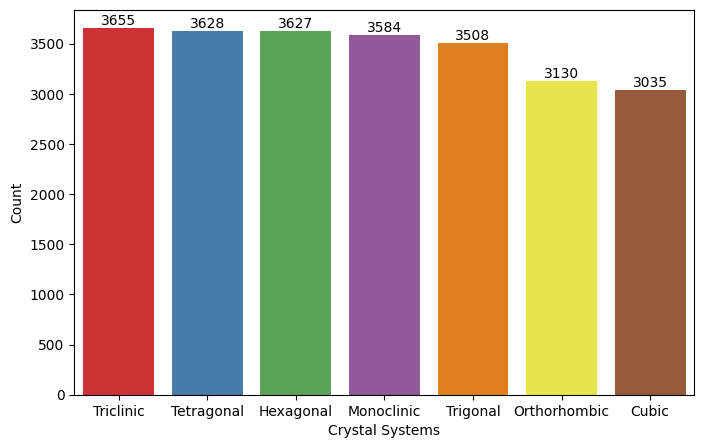

In [8]:
# Bar plot of class count
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv('M7.csv')

# Count occurrences of each crystal system
crystal_counts = df["crystal_system"].value_counts()
print(crystal_counts)

# Plot bar graph
plt.figure(figsize=(8,5))
ax = sns.barplot(
    x=crystal_counts.index,
    y=crystal_counts.values,
    hue=crystal_counts.index,
    legend=False,
    palette='Set1'
)

# Add counts on top of bars
for i, value in enumerate(crystal_counts.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

# Labels and title
plt.xlabel("Crystal Systems")
plt.ylabel("Count")


# Save as PNG with dpi=400
plt.savefig("crystal_system_counts.png", dpi=400, bbox_inches="tight")

plt.show()

# Creation of M4

In [11]:
# ---------------- Remove Duplicates & Compare Counts ----------------
import pandas as pd

# Define compound-identifying columns
compound_cols = ['ARR_A','ARR_B','MPR_A','MPR_B','END_A','END_B',
                 'OF','t','BL_AB','BL_AX','BL_BX','ENR']

# Load original dataset
df_original = pd.read_csv("Master_V7_new_decorrelated.csv")

# Count unique compounds before cleaning
before_count = df_original[compound_cols].drop_duplicates().shape[0]

# Remove duplicate rows (based on compound columns)
df_cleaned = df_original.drop_duplicates(subset=compound_cols, keep=False)

# Save cleaned dataset
df_cleaned.to_csv("M4_imbalanced.csv", index=False)

# Count unique compounds after cleaning
after_count = df_cleaned[compound_cols].drop_duplicates().shape[0]

# Print comparison
print("🧮 Unique compound count comparison:")
print(f"🔹 Before duplicate removal: {before_count}")
print(f"🔹 After duplicate removal:  {after_count}")
print("✅ Cleaned dataset saved as M4_imbalanced.csv")


🧮 Unique compound count comparison:
🔹 Before duplicate removal: 5279
🔹 After duplicate removal:  4502
✅ Cleaned dataset saved as M4_imbalanced.csv


crystal_system
Cubic           3035
Orthorhombic    1155
Trigonal         243
Tetragonal        69
Name: count, dtype: int64


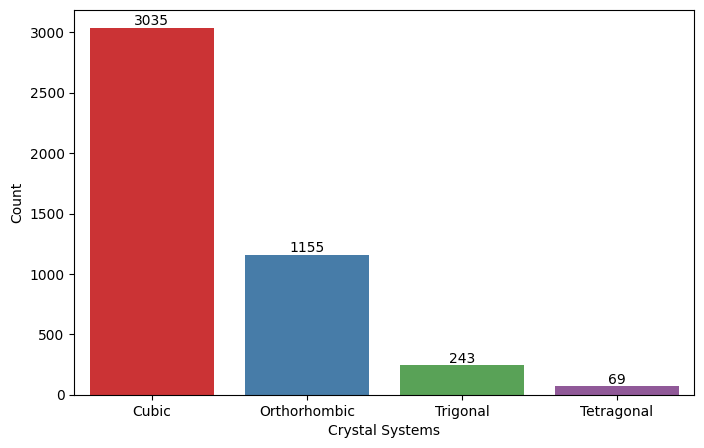

In [13]:
# Bar plot of class count
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
df=pd.read_csv('M4_imbalanced.csv')

# Count occurrences of each crystal system
crystal_counts = df["crystal_system"].value_counts()
print(crystal_counts)

# Plot bar graph
plt.figure(figsize=(8,5))
ax = sns.barplot(
    x=crystal_counts.index,
    y=crystal_counts.values,
    hue=crystal_counts.index,
    legend=False,
    palette='Set1'
)

# Add counts on top of bars
for i, value in enumerate(crystal_counts.values):
    ax.text(i, value + 0.5, str(value), ha='center', va='bottom', fontsize=10)

# Labels and title
plt.xlabel("Crystal Systems")
plt.ylabel("Count")


# Save as PNG with dpi=400
plt.savefig("crystal_system_counts.png", dpi=400, bbox_inches="tight")

plt.show()

In [15]:
# ---------------- Balancing with SMOTE ----------------
from imblearn.over_sampling import SMOTE
from collections import Counter
import pandas as pd

# Separate target
y = df['crystal_system']

# Remove non-numeric columns (keep only numeric ones for SMOTE)
non_numeric_cols = ['Formula', 'A', 'B', 'crystal_system']
X = df.drop(columns=non_numeric_cols, errors='ignore')

print("Before balancing:", Counter(y))

# Apply SMOTE
sm = SMOTE(random_state=42)
X_balanced, y_balanced = sm.fit_resample(X, y)

print("After balancing:", Counter(y_balanced))

# Build balanced DataFrame
df_balanced = pd.DataFrame(X_balanced, columns=X.columns)
df_balanced['crystal_system'] = y_balanced

# Save
df_balanced.to_csv("M4.csv", index=False)
print("✅ Balanced dataset saved as M4.csv")


Before balancing: Counter({'Cubic': 3035, 'Orthorhombic': 1155, 'Trigonal': 243, 'Tetragonal': 69})
After balancing: Counter({'Cubic': 3035, 'Orthorhombic': 3035, 'Trigonal': 3035, 'Tetragonal': 3035})
✅ Balanced dataset saved as M4.csv


# Master Encoded

In [16]:
#Encoded file for Binary Classification DataSets
import pandas as pd
from sklearn.preprocessing import MultiLabelBinarizer
df=pd.read_csv("Master_File.csv")
labels_grouped = df.groupby('Formula')['crystal_system'].apply(list)

# 2. Group features (pick the first occurrence)
features_grouped = df.drop(columns='crystal_system').drop_duplicates(subset='Formula').set_index('Formula')

# 3. Apply multi-label binarizer
mlb = MultiLabelBinarizer()
labels_encoded = pd.DataFrame(
    mlb.fit_transform(labels_grouped),
    index=labels_grouped.index,
    columns=mlb.classes_
)

# 4. Combine features with encoded labels
final_df = pd.concat([features_grouped, labels_encoded], axis=1).reset_index()
final_df.to_csv('Master_encoded.csv', index=False)
print("✅ Encoded dataset saved as 'Master_encoded.csv'")

✅ Encoded dataset saved as 'Master_encoded.csv'


In [17]:
#Making Balanced Binary Files for each Crystal System
import pandas as pd
from imblearn.over_sampling import SMOTE
import os

df= pd.read_csv("Master_encoded.csv")
df = df.drop(columns=["Formula","A","B"])

# ---- 2. Separate features (X) and multilabel targets (Y) ----
# Assuming last N columns are the multilabels
N_LABELS = 7  # 👈 Replace with the actual number of labels in your dataset
X = df.iloc[:, :-N_LABELS]
Y = df.iloc[:, -N_LABELS:]

# ---- 3. Apply SMOTE independently to each label ----
from collections import defaultdict

balanced_datasets = defaultdict(dict)

for label in Y.columns:
    print(f"Processing label: {label}")

    sm = SMOTE(random_state=42)

    y_label = Y[label]
    try:
        X_res, y_res = sm.fit_resample(X, y_label)
        balanced_datasets[label]["X"] = X_res
        balanced_datasets[label]["y"] = y_res

        print(f"Original: {sum(y_label==1)} positive / {sum(y_label==0)} negative")
        print(f"Resampled: {sum(y_res==1)} positive / {sum(y_res==0)} negative")
        print("---")
    except ValueError as e:
        print(f"Skipping label {label}: {e}")

# Saving the balanced datasets to CSV
for i in range(7):
    label_to_save = list(balanced_datasets.keys())[i]
    df_balanced = pd.DataFrame(balanced_datasets[label_to_save]["X"])
    df_balanced[label_to_save] = balanced_datasets[label_to_save]["y"]
    df_balanced.to_csv(f"balanced_{label_to_save}.csv", index=False)
    print(f"Saved balanced dataset for label: {label_to_save}")

Processing label: Cubic
Original: 3726 positive / 1553 negative
Resampled: 3726 positive / 3726 negative
---
Processing label: Hexagonal
Original: 99 positive / 5180 negative
Resampled: 5180 positive / 5180 negative
---
Processing label: Monoclinic
Original: 142 positive / 5137 negative
Resampled: 5137 positive / 5137 negative
---
Processing label: Orthorhombic
Original: 1751 positive / 3528 negative
Resampled: 3528 positive / 3528 negative
---
Processing label: Tetragonal
Original: 167 positive / 5112 negative
Resampled: 5112 positive / 5112 negative
---
Processing label: Triclinic
Original: 71 positive / 5208 negative
Resampled: 5208 positive / 5208 negative
---
Processing label: Trigonal
Original: 461 positive / 4818 negative
Resampled: 4818 positive / 4818 negative
---
Saved balanced dataset for label: Cubic
Saved balanced dataset for label: Hexagonal
Saved balanced dataset for label: Monoclinic
Saved balanced dataset for label: Orthorhombic
Saved balanced dataset for label: Tetrag

Train size: (4223, 47)
Test size: (1056, 47)
Cubic: class counts after balancing -> {0: 2968, 1: 2968}
Hexagonal: class counts after balancing -> {0: 4135, 1: 4135}
Monoclinic: class counts after balancing -> {0: 4104, 1: 4104}
Orthorhombic: class counts after balancing -> {1: 2803, 0: 2803}
Tetragonal: class counts after balancing -> {0: 4087, 1: 4087}
Triclinic: class counts after balancing -> {0: 4163, 1: 4163}
Trigonal: class counts after balancing -> {0: 3847, 1: 3847}


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:44:51] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 2374, number of negative: 2374
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002429 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8037
[LightGBM] [Info] Number of data points in the train set: 4748, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:45:29] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 3308, number of negative: 3308
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003135 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7998
[LightGBM] [Info] Number of data points in the train set: 6616, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:46:01] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 3283, number of negative: 3283
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003192 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8058
[LightGBM] [Info] Number of data points in the train set: 6566, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:46:39] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 2242, number of negative: 2242
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002144 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 7991
[LightGBM] [Info] Number of data points in the train set: 4484, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:47:12] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 3270, number of negative: 3269
[LightGBM] [Info] Auto-choosing row-wise multi-threading, the overhead of testing was 0.001519 seconds.
You can set `force_row_wise=true` to remove the overhead.
And if memory is not enough, you can set `force_col_wise=true`.
[LightGBM] [Info] Total Bins 8155
[LightGBM] [Info] Number of data points in the train set: 6539, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500076 -> initscore=0.000306
[LightGBM] [Info] Start training from score 0.000306


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:47:48] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 3330, number of negative: 3330
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.003412 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8056
[LightGBM] [Info] Number of data points in the train set: 6660, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500000 -> initscore=0.000000


/usr/local/lib/python3.12/dist-packages/xgboost/training.py:183: UserWarning: [04:48:17] WARNING: /workspace/src/learner.cc:738: 
Parameters: { "use_label_encoder" } are not used.

  bst.update(dtrain, iteration=i, fobj=obj)


[LightGBM] [Info] Number of positive: 3078, number of negative: 3077
[LightGBM] [Info] Auto-choosing col-wise multi-threading, the overhead of testing was 0.002990 seconds.
You can set `force_col_wise=true` to remove the overhead.
[LightGBM] [Info] Total Bins 8191
[LightGBM] [Info] Number of data points in the train set: 6155, number of used features: 37
[LightGBM] [Info] [binary:BoostFromScore]: pavg=0.500081 -> initscore=0.000325
[LightGBM] [Info] Start training from score 0.000325
Accuracy results saved to crystal_system_accuracy.csv


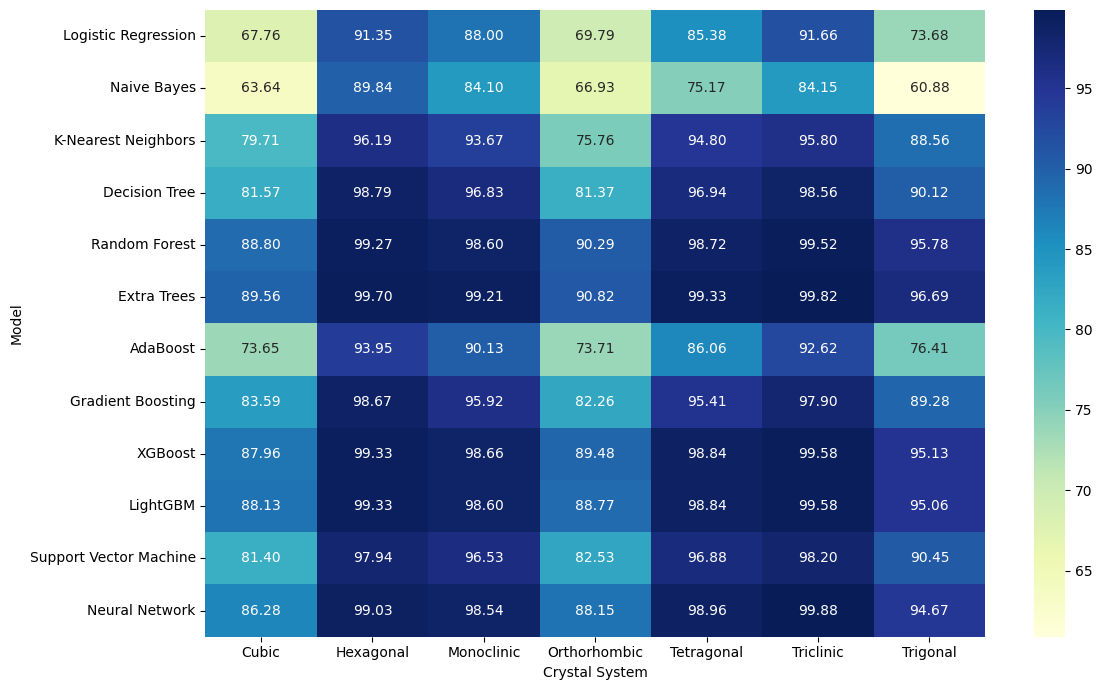

In [25]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.model_selection import train_test_split
from sklearn.preprocessing import StandardScaler
from sklearn.pipeline import make_pipeline
from sklearn.metrics import accuracy_score

from sklearn.linear_model import LogisticRegression
from sklearn.naive_bayes import GaussianNB
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import (
    RandomForestClassifier, ExtraTreesClassifier,
    AdaBoostClassifier, GradientBoostingClassifier
)
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier

import xgboost as xgb
import lightgbm as lgb

from imblearn.over_sampling import SMOTE

# ---------------------------
# Load dataset
# ---------------------------
df = pd.read_csv("Master_encoded.csv")

# Crystal system columns (binary 0/1)
crystal_systems = ['Cubic', 'Hexagonal', 'Monoclinic',
                   'Orthorhombic', 'Tetragonal', 'Triclinic', 'Trigonal']

# Keep only numeric feature columns
X_all = df.drop(columns=['Formula'] + crystal_systems, errors="ignore")
X_all = X_all.select_dtypes(include=['number'])

# ---------------------------
# Step 1: Split dataset (20% test, 80% train)
# ---------------------------
train_df, test_df = train_test_split(df, test_size=0.2, random_state=42)


print("Train size:", train_df.shape)
print("Test size:", test_df.shape)

# ---------------------------
# Step 2 & 3: Create 7 binary datasets and balance them
# ---------------------------
balanced_datasets = {}
for system in crystal_systems:
    y = train_df[system]
    X = train_df.drop(columns=['Formula'] + crystal_systems, errors="ignore")
    X = X.select_dtypes(include=['number'])

    # Balance with SMOTE
    smote = SMOTE(random_state=42)
    X_bal, y_bal = smote.fit_resample(X, y)

    balanced_datasets[system] = (X_bal, y_bal)
    print(f"{system}: class counts after balancing -> {pd.Series(y_bal).value_counts().to_dict()}")

# ---------------------------
# Step 4: Define models
# ---------------------------
models = {
    "Logistic Regression": make_pipeline(StandardScaler(), LogisticRegression(max_iter=2000, random_state=42)),
    "Naive Bayes": GaussianNB(),
    "K-Nearest Neighbors": KNeighborsClassifier(),
    "Decision Tree": DecisionTreeClassifier(random_state=42),
    "Random Forest": RandomForestClassifier(random_state=42),
    "Extra Trees": ExtraTreesClassifier(random_state=42),
    "AdaBoost": AdaBoostClassifier(random_state=42),
    "Gradient Boosting": GradientBoostingClassifier(random_state=42),
    "XGBoost": xgb.XGBClassifier(use_label_encoder=False, eval_metric="logloss", random_state=42),
    "LightGBM": lgb.LGBMClassifier(random_state=42),
    "Support Vector Machine": make_pipeline(StandardScaler(), SVC(random_state=42)),
    "Neural Network": make_pipeline(StandardScaler(), MLPClassifier(max_iter=2000, random_state=42)),
}

# ---------------------------
# Step 5: Binary classification on 7 datasets
# ---------------------------
results = pd.DataFrame(index=models.keys(), columns=crystal_systems, dtype=float)

for system in crystal_systems:
    X_bal, y_bal = balanced_datasets[system]

    # Split balanced dataset into train/validation
    X_train, X_val, y_train, y_val = train_test_split(
        X_bal, y_bal, test_size=0.2, random_state=42, stratify=y_bal
    )

    for model_name, model in models.items():
        clf = model
        clf.fit(X_train, y_train)
        y_pred = clf.predict(X_val)
        acc = accuracy_score(y_val, y_pred) * 100
        results.loc[model_name, system] = acc

# ---------------------------
# Step 6: Save & plot results
# ---------------------------
results.to_csv("crystal_system_accuracy.csv", index=True)
print("Accuracy results saved to crystal_system_accuracy.csv")

plt.figure(figsize=(12, 7))
sns.heatmap(results, annot=True, fmt=".2f", cmap="YlGnBu")
plt.ylabel("Model")
plt.xlabel("Crystal System")

plt.tight_layout()

plt.savefig("crystal_system_accuracy_final.png", dpi=400, bbox_inches="tight")
plt.show()

/tmp/ipython-input-2422763249.py:22: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `y` variable to `hue` and set `legend=False` for the same effect.

  sns.barplot(


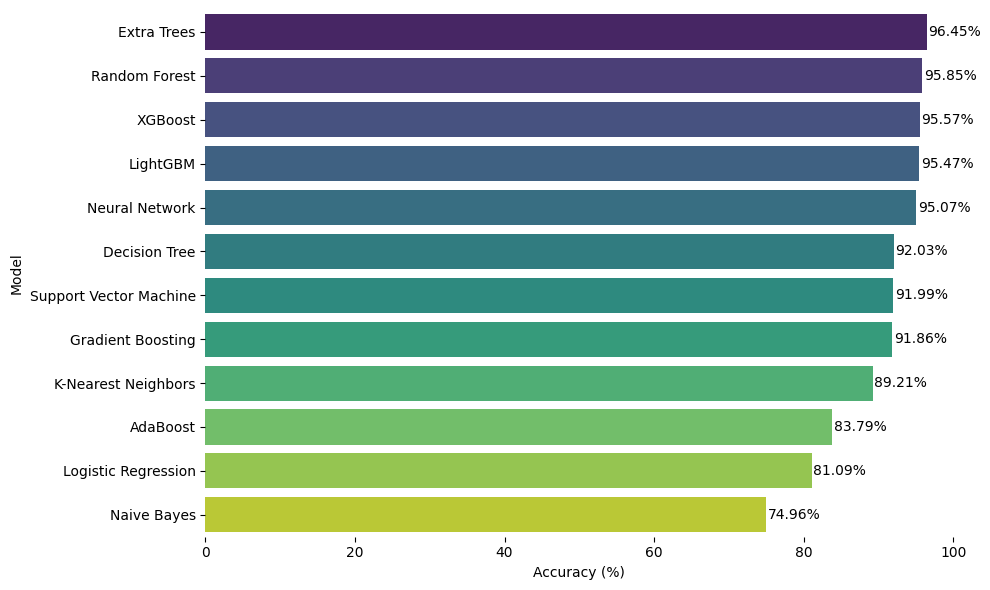

In [26]:
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

# Load results from CSV

results = pd.read_csv("crystal_system_accuracy.csv", index_col=0)

# Compute average accuracy across all crystal systems

results["Average Accuracy"] = results.mean(axis=1)

# Sort models by average accuracy
results_sorted = results["Average Accuracy"].sort_values(ascending=False)

# Plot horizontal bar chart 

plt.figure(figsize=(10, 6))
sns.barplot(
    x=results_sorted.values,
    y=results_sorted.index,
    palette="viridis"
)

# Add percentage labels
for i, v in enumerate(results_sorted.values):
    plt.text(v + 0.2, i, f"{v:.2f}%", va="center")

plt.xlabel("Accuracy (%)")
plt.ylabel("Model")
plt.xlim(0, 100)

# Remove plot spines (box edges)
sns.despine(left=True, bottom=True)

plt.tight_layout()

# Save high-resolution image
plt.savefig("average_model_performance.png", dpi=400, bbox_inches="tight")

# Show plot
plt.show()